# Esse código utiliza como DB uma tradução que foi feita de reviews no IMDB e treina os dados de acordo com o que foi escrito para definir filmes 'ruins'(0) ou 'bons'(1)

## Importando bibliotecas

In [84]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import tokenize
from nltk import ngrams
from string import punctuation
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Verificando se a GPU está sendo usada

In [85]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## Importando dados

In [86]:
# acessando dados da planilha que foi baixada
dados = pd.read_csv("imdb-reviews-pt-br.csv")
# definindo coluna id como index
dados = dados.set_index('id')
# dropando coluna text_en
dados = dados.drop('text_en', 1)
# renomeando colunas para português
a_renomear = {
    'text_pt': 'texto_portugues',
    'sentiment': 'classificacao'
}
dados = dados.rename(columns=a_renomear)
# alterando dados da coluna classificacao para 0 ou 1
a_trocar = {'neg': 0, 'pos': 1}
dados.classificacao = dados.classificacao.map(a_trocar)
#criando uma ramificação 'cru' para motivos de comparações futuras
print(dados)

                                         texto_portugues  classificacao
id                                                                     
1      Mais uma vez, o Sr. Costner arrumou um filme p...              0
2      Este é um exemplo do motivo pelo qual a maiori...              0
3      Primeiro de tudo eu odeio esses raps imbecis, ...              0
4      Nem mesmo os Beatles puderam escrever músicas ...              0
5      Filmes de fotos de latão não é uma palavra apr...              0
...                                                  ...            ...
49456  Como a média de votos era muito baixa, e o fat...              1
49457  O enredo teve algumas reviravoltas infelizes e...              1
49458  Estou espantado com a forma como este filme e ...              1
49459  A Christmas Together realmente veio antes do m...              1
49460  O drama romântico da classe trabalhadora do di...              1

[49459 rows x 2 columns]


## Tratando dados

In [87]:
#retirando acentuação
sem_acentos = [unidecode(texto) for texto in dados["texto_portugues"]]
dados["texto_portugues"] = sem_acentos

#criando uma lista com pontuação
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

# retiando palavras irrelevantes e pontuação do df
stop_words = nltk.corpus.stopwords.words("portuguese")
stop_words = [unidecode(texto) for texto in stop_words]
stop_words += pontuacao
# print(stop_words)

# criando uma lista 'frase_processada' sem as stopwords
token_pontuacao = tokenize.WordPunctTokenizer()
frase_processada = list()

for i in dados.texto_portugues:
    nova_frase = list()
    i = i.lower()
    palavras_texto = token_pontuacao.tokenize(i)
    for palavra in palavras_texto:
        if palavra not in stop_words:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

# inserindo coluna tratada e dados
dados.insert(1, "tratamento_1", frase_processada)
print(dados)

                                         texto_portugues  \
id                                                         
1      Mais uma vez, o Sr. Costner arrumou um filme p...   
2      Este e um exemplo do motivo pelo qual a maiori...   
3      Primeiro de tudo eu odeio esses raps imbecis, ...   
4      Nem mesmo os Beatles puderam escrever musicas ...   
5      Filmes de fotos de latao nao e uma palavra apr...   
...                                                  ...   
49456  Como a media de votos era muito baixa, e o fat...   
49457  O enredo teve algumas reviravoltas infelizes e...   
49458  Estou espantado com a forma como este filme e ...   
49459  A Christmas Together realmente veio antes do m...   
49460  O drama romantico da classe trabalhadora do di...   

                                            tratamento_1  classificacao  
id                                                                       
1      vez sr costner arrumou filme tempo necessario ...              0

## Aplicando função Stemmer

In [88]:
frase_processada_stemmer = list()
stemmer = nltk.RSLPStemmer()

for i in dados.tratamento_1:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(i)
    for palavra in palavras_texto:
        nova_frase.append(stemmer.stem(palavra))
    frase_processada_stemmer.append(' '.join(nova_frase))

dados.insert(2, "trat_stemmer", frase_processada_stemmer)
print(dados)

                                         texto_portugues  \
id                                                         
1      Mais uma vez, o Sr. Costner arrumou um filme p...   
2      Este e um exemplo do motivo pelo qual a maiori...   
3      Primeiro de tudo eu odeio esses raps imbecis, ...   
4      Nem mesmo os Beatles puderam escrever musicas ...   
5      Filmes de fotos de latao nao e uma palavra apr...   
...                                                  ...   
49456  Como a media de votos era muito baixa, e o fat...   
49457  O enredo teve algumas reviravoltas infelizes e...   
49458  Estou espantado com a forma como este filme e ...   
49459  A Christmas Together realmente veio antes do m...   
49460  O drama romantico da classe trabalhadora do di...   

                                            tratamento_1  \
id                                                         
1      vez sr costner arrumou filme tempo necessario ...   
2      exemplo motivo maioria filmes ac

## Treinando modelo

In [89]:
def treino_teste_texto(dados, feature, classificacao):
    # transformando a frase para um vetor de representação com tamanho máximo de n=50
    vetorizar = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
    bag_of_words = vetorizar.fit_transform(dados[feature])

    SEED = 42
    np.random.seed(SEED)
    treino_x, teste_x, treino_y, teste_y = train_test_split(
        bag_of_words, dados[classificacao], stratify=dados[classificacao])
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(treino_x, treino_y)
    acuracia = regressao_logistica.score(
        teste_x, teste_y)
    return acuracia

## Gerando WordCloud

In [90]:
def nuvem_palavras(dados, feature, classe):
    # filtrando avaliações negativas(0) ou positivas(1)
    texto = dados.query(f"classificacao == {classe}")
    # criando vetor com todas as palavras
    todas_palavras = ' '.join([texto for texto in texto[feature]])

    # criando a wordcloud e imprimindo a imagem
    # os parâmetros são opcionais, verificar documentação
    nuvem_palavras = WordCloud(width=800, height=500,
                            max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10, 7))  # figsize define o tamanho da imagem
    # bilinear = mais nitida a img
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")  # retira os valores dos eixos x e y
    plt.show()

## Definindo frequencia e plotando gráfico com palavras mais frequentes

In [91]:
def freq_palavras(dados, feature, classe, qtde_de_registros):
    # filtrando por avaliações negativas(0) ou positivas(1)
    texto = dados.query(f"classificacao == {classe}")

    # criando vetor com todas as palavras
    todas_palavras = ' '.join([texto for texto in texto[feature]])

    # criando uma lista com cada palavra em um indice, separando por espaço
    token_espaco = tokenize.WhitespaceTokenizer()
    token_frase = token_espaco.tokenize(todas_palavras)
    registros = nltk.FreqDist(token_frase)

    # criando df
    df_frequencia = pd.DataFrame({"Palavra": list(registros.keys()),
                                "Frequencia": list(registros.values())})
    df_frequencia = df_frequencia.sort_values(
        by=['Frequencia'], ascending=False)
    print(df_frequencia.head(qtde_de_registros))

    #definindo quantidade de palavras a serem vistas
    registros = df_frequencia.nlargest(columns="Frequencia", n=qtde_de_registros)
    #plotando gráfico
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=registros, x="Palavra", y="Frequencia", color='gray')
    ax.set(ylabel = "Frequencia")
    plt.show()

# **Verificando Resultados:**

## Treino e testes:

### Brutos:

In [108]:
print(treino_teste_texto(dados, "texto_portugues", "classificacao"))

0.8887990295188031


### Tratados:

In [109]:
print(treino_teste_texto(dados, "trat_stemmer", "classificacao"))

0.8879902951880307


## Nuvens de palavras:

### Dados Brutos, Ruins(0) e Boas(1):

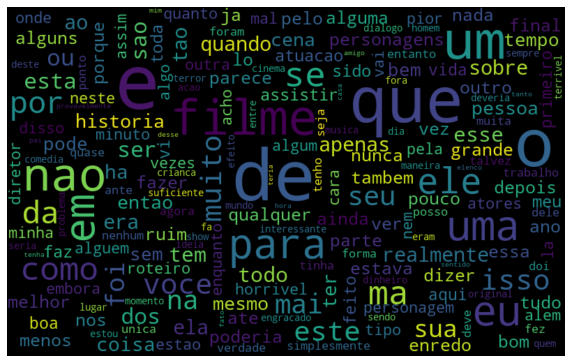

In [98]:
nuvem_palavras(dados, "texto_portugues", 0)

In [ ]:
nuvem_palavras(dados, "texto_portugues", 1)

### Dados Tratados, Ruins(0) e Boas(1):

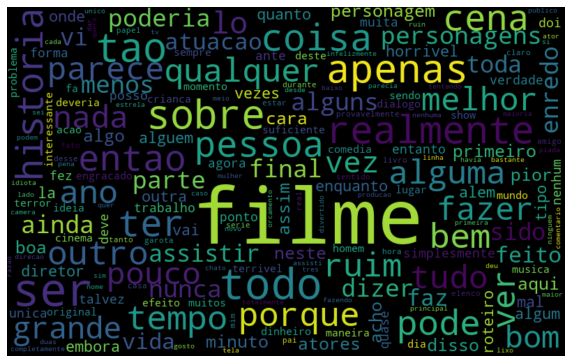

In [106]:
nuvem_palavras(dados, "tratamento_1", 0)

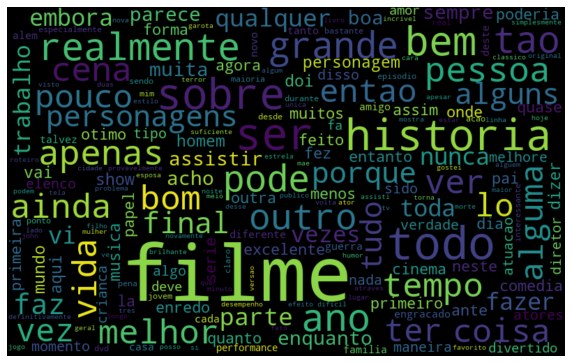

In [107]:
nuvem_palavras(dados, "tratamento_1", 1)

## Frequencia de palavras e Gráfico de pareto:

### Dados Brutos, Ruins(0) e Boas(1):

    Palavra  Frequencia
42        e      230860
20       de      209551
14      que      167826
3         o      123068
100       a      108284
7        um      107502
29      nao       73731
1       uma       64640
114    para       64279
198      em       63951


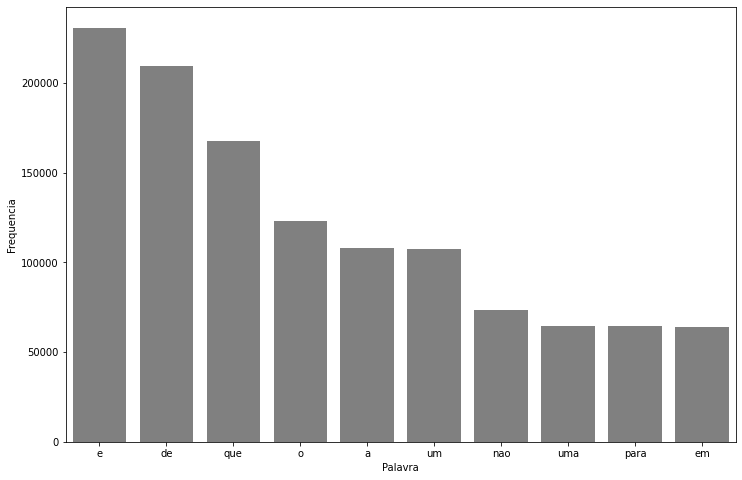

In [102]:
freq_palavras(dados, "texto_portugues", 0, 10)

    Palavra  Frequencia
2         e      261943
10       de      208922
18      que      157525
37        o      121854
7         a      114200
52       um      108936
21       em       69101
150     uma       66257
129    para       62614
5     filme       55743


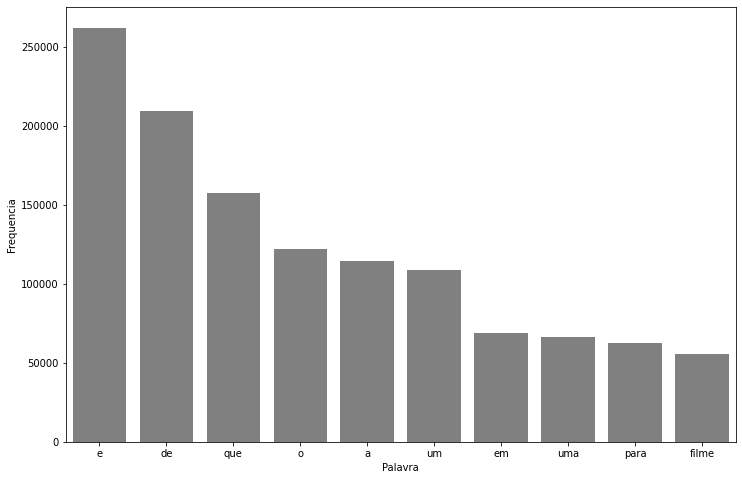

In [103]:
freq_palavras(dados, "texto_portugues", 1, 10)

### Dados Tratados, Ruins(0) e Boas(1):

    Palavra  Frequencia
4      film      101089
64      pod       23296
126     tod       22542
442   algum       20761
57      ser       20101
65      faz       19995
107    real       18377
46    parec       16683
54     sobr       14507
195     tao       14340


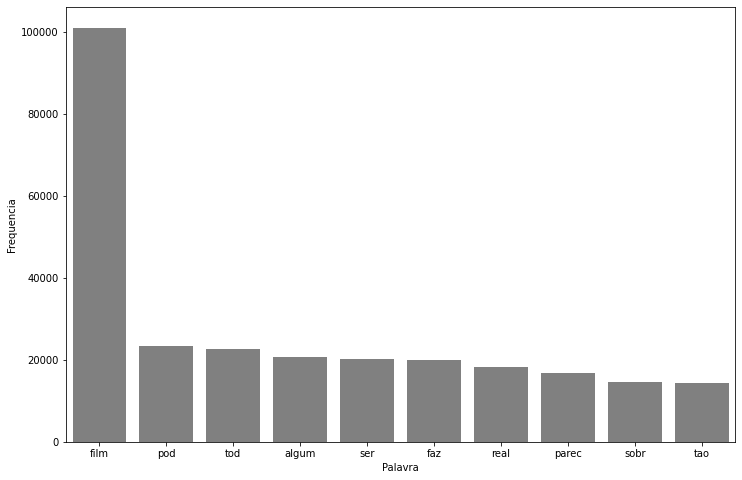

In [104]:
freq_palavras(dados, "trat_stemmer", 0, 10)

    Palavra  Frequencia
1      film       91335
38      tod       23074
33      pod       20429
199    real       18171
17      faz       17157
6     algum       17046
4       ser       16787
198    hist       15082
79     sobr       15024
321    outr       14815


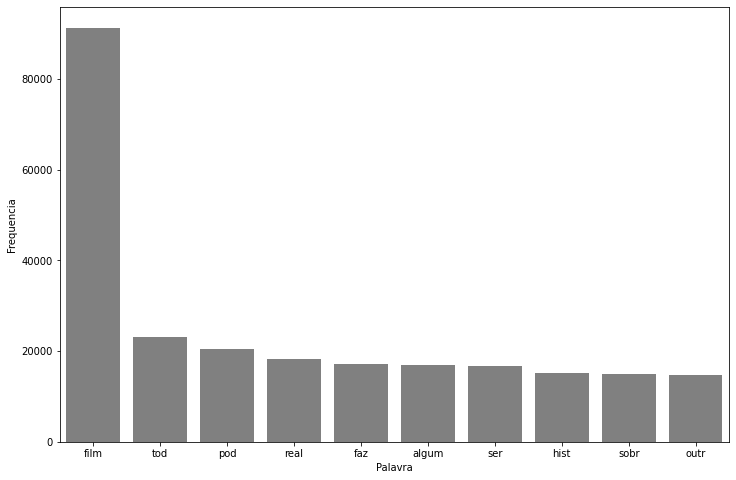

In [105]:
freq_palavras(dados, "trat_stemmer", 1, 10)